In [1]:
from esm.models.esmc import ESMC
import pandas as pd
from glycowork.ml.inference import get_lectin_preds, get_esmc_representations
from glycowork.ml.models import prep_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from Bio import SeqIO

c:\Users\Logan\miniconda3\envs\glycan-summer-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
esm_model = ESMC.from_pretrained("esmc_300m")
leor = prep_model("LectinOracle", 1, trained = True)

Fetching 4 files: 100%|██████████| 4/4 [00:00<?, ?it/s]


Download completed.


## Load Data

In [3]:
left_glycan_df = pd.read_csv('data/SMILES-L-sugars.txt', sep='\t')
left_glycan_df = left_glycan_df.drop("SMILES", axis=1)
left_glycan_df

,Name,IUPAC
0,L-aMan-Sp8,L-Man(α-Sp8
1,L-Rha-Sp8,L-Rha(α-Sp8
2,L-Gal-Sp8,L-Gal(α-Sp8
3,L-Glc-Sp8,L-Glc(α-Sp8


In [4]:
left_handed_glycans = ["Rha"]

def get_clean_iupacs(glycans):
    clean_glycans = []
    for glycan in glycans:
        #remove spacer
        if glycan.count('(') > glycan.count(')'):
            spacer_pos = glycan.rfind('(')
            glycan = glycan[:spacer_pos]
        # remove L- prefix for covnetionally left-handed glycans
        if glycan[2:] in left_handed_glycans:
            glycan = glycan[2:]
        clean_glycans.append(glycan)
    return clean_glycans

In [5]:
left_glycan_df["Clean IUPAC"] = get_clean_iupacs(left_glycan_df["IUPAC"])
left_glycan_df

,Name,IUPAC,Clean IUPAC
0,L-aMan-Sp8,L-Man(α-Sp8,L-Man
1,L-Rha-Sp8,L-Rha(α-Sp8,Rha
2,L-Gal-Sp8,L-Gal(α-Sp8,L-Gal
3,L-Glc-Sp8,L-Glc(α-Sp8,L-Glc


In [6]:
# list to collect parsed records
records_list = []

for record in SeqIO.parse("data/lectin-sequence-subset.fasta", "fasta"):
    header_parts = record.description.split(" ")

    uniprot_id = header_parts[0].split("|")[1]
    entry_name = header_parts[0].split("|")[2]

    # Get positions of OS= (organism species start)
    try:
        os_index = next(i for i, s in enumerate(header_parts) if s.startswith("OS="))
    except StopIteration:
        os_index = None

    # Protein name is from after entry_name (index 0) up to OS=
    protein_name = " ".join(header_parts[1:os_index])

    # Extract fields safely if present
    os = next((part.split("=")[1] for part in header_parts if part.startswith("OS=")), None)
    ox = next((part.split("=")[1] for part in header_parts if part.startswith("OX=")), None)
    gn = next((part.split("=")[1] for part in header_parts if part.startswith("GN=")), None)
    pe = next((part.split("=")[1] for part in header_parts if part.startswith("PE=")), None)
    sv = next((part.split("=")[1] for part in header_parts if part.startswith("SV=")), None)

    sequence = str(record.seq)

    records_list.append({
        "Accession": uniprot_id,
        "EntryName": entry_name,
        "ProteinName": protein_name,
        "Organism": os,
        "TaxonomyID": ox,
        "Gene": gn,
        "ProteinExistence": pe,
        "SequenceVersion": sv,
        "Sequence": sequence
    })

# Optional: convert to pandas DataFrame
import pandas as pd
protein_fasta = pd.DataFrame(records_list)

print(len(protein_fasta))
protein_fasta

9


,Accession,EntryName,ProteinName,Organism,TaxonomyID,Gene,ProteinExistence,SequenceVersion,Sequence
0,P05046,LEC_SOYBN,Lectin,Glycine,3847,LE1,1,1,MATSKLKTQNVVVSLSLTLTLVLVLLTSKANSAETVSFSWNKFVPK...
1,P06750,AGGL_RICCO,Agglutinin,Ricinus,3988,None,1,1,MYAVATWLCFGSTSGWSFTLEDNNIFPKQYPIINFTTADATVESYT...
2,P09382,LEG1_HUMAN,Galectin-1,Homo,9606,LGALS1,1,2,MACGLVASNLNLKPGECLRVRGEVAPDAKSFVLNLGKDSNNLCLHF...
3,P02866,CONA_CANEN,Concanavalin-A,Canavalia,3823,None,1,2,MAISKKSSLFLPIFTFITMFLMVVNKVSSSTHETNALHFMFNQFSK...
4,P17931,LEG3_HUMAN,Galectin-3,Homo,9606,LGALS3,1,5,MADNFSLHDALSGSGNPNPQGWPGAWGNQPAGAGGYPGASYPGAYP...
5,P18891,LECF_ALEAU,Fucose-specific lectin,Aleuria,5188,None,1,3,MPTEFLYTSKIAAISWAATGGRQQRVYFQDLNGKIREAQRGGDNPW...
6,P22972,LEC1_ULEEU,Anti-H(O) lectin 1,Ulex,3902,None,1,1,SDDLSFKFKNFSQNGKDLSFQGDASVIETGVLQLNKVGNNLPDETG...
7,P47929,LEG7_HUMAN,Galectin-7,Homo,9606,LGALS7,1,2,MSNVPHKSSLPEGIRPGTVLRIRGLVPPNASRFHVNLLCGEEQGSD...
8,P83410,LEC_ERYCG,Lectin (Fragment),Erythrina,49817,None,1,1,VETISFSFSEFEPGNDNLTLQGAALITQSGVLQLTKINQNGMPAWD...


In [7]:
protein_df = protein_fasta[["ProteinName", "Sequence"]]
protein_df = protein_df.rename(columns={"ProteinName": "Name"})
protein_df

,Name,Sequence
0,Lectin,MATSKLKTQNVVVSLSLTLTLVLVLLTSKANSAETVSFSWNKFVPK...
1,Agglutinin,MYAVATWLCFGSTSGWSFTLEDNNIFPKQYPIINFTTADATVESYT...
2,Galectin-1,MACGLVASNLNLKPGECLRVRGEVAPDAKSFVLNLGKDSNNLCLHF...
3,Concanavalin-A,MAISKKSSLFLPIFTFITMFLMVVNKVSSSTHETNALHFMFNQFSK...
4,Galectin-3,MADNFSLHDALSGSGNPNPQGWPGAWGNQPAGAGGYPGASYPGAYP...
5,Fucose-specific lectin,MPTEFLYTSKIAAISWAATGGRQQRVYFQDLNGKIREAQRGGDNPW...
6,Anti-H(O) lectin 1,SDDLSFKFKNFSQNGKDLSFQGDASVIETGVLQLNKVGNNLPDETG...
7,Galectin-7,MSNVPHKSSLPEGIRPGTVLRIRGLVPPNASRFHVNLLCGEEQGSD...
8,Lectin (Fragment),VETISFSFSEFEPGNDNLTLQGAALITQSGVLQLTKINQNGMPAWD...


In [8]:
# mapping from protein name in fasta file to the correct acronym
protein_to_acronym = {
    "Lectin": "SBA",
    "Agglutinin": "RCA",
    "Fucose-specific lectin": "AAL", 
    "Anti-H(O) lectin 1": "UEA-I",
    "Lectin (Fragment)": "ECL", 
    "Concanavalin-A": "ConA",
}

In [9]:
protein_df["Acronym"] = [protein_to_acronym[protein] if protein in protein_to_acronym else protein for protein in protein_df["Name"]]
protein_df

,Name,Sequence,Acronym
0,Lectin,MATSKLKTQNVVVSLSLTLTLVLVLLTSKANSAETVSFSWNKFVPK...,SBA
1,Agglutinin,MYAVATWLCFGSTSGWSFTLEDNNIFPKQYPIINFTTADATVESYT...,RCA
2,Galectin-1,MACGLVASNLNLKPGECLRVRGEVAPDAKSFVLNLGKDSNNLCLHF...,Galectin-1
3,Concanavalin-A,MAISKKSSLFLPIFTFITMFLMVVNKVSSSTHETNALHFMFNQFSK...,ConA
4,Galectin-3,MADNFSLHDALSGSGNPNPQGWPGAWGNQPAGAGGYPGASYPGAYP...,Galectin-3
5,Fucose-specific lectin,MPTEFLYTSKIAAISWAATGGRQQRVYFQDLNGKIREAQRGGDNPW...,AAL
6,Anti-H(O) lectin 1,SDDLSFKFKNFSQNGKDLSFQGDASVIETGVLQLNKVGNNLPDETG...,UEA-I
7,Galectin-7,MSNVPHKSSLPEGIRPGTVLRIRGLVPPNASRFHVNLLCGEEQGSD...,Galectin-7
8,Lectin (Fragment),VETISFSFSEFEPGNDNLTLQGAALITQSGVLQLTKINQNGMPAWD...,ECL


## Prediction Functions

In [10]:
def get_pred_df(protein_df, glycan_df):
    leor_preds = {"glycan": [], "protein": [], "rfu": []}
    for i, prot_row in protein_df.iterrows():
        sequence = prot_row["Sequence"]
        protein = prot_row["Acronym"]
        rep = get_esmc_representations([sequence], esm_model)
        preds = get_lectin_preds(sequence, glycan_df["Clean IUPAC"], leor, rep)
        for j, pred_row in preds.iterrows():
            glycan = glycan_df.loc[glycan_df['Clean IUPAC'] == pred_row["motif"], 'Name'].values[0]
            rfu = pred_row["pred"]

            leor_preds["glycan"].append(glycan)
            leor_preds["protein"].append(protein)
            leor_preds["rfu"].append(rfu)
            
    return pd.DataFrame(leor_preds)

In [11]:
def plot_table(preds_df, file_name, title):
    pivot_df = preds_df.pivot(index='glycan', columns='protein', values='rfu')

    fig, ax = plt.subplots()
    data = (pivot_df > 0).values.astype(int)

    # Display heatmap
    cmap = colors.ListedColormap(['red', 'green'])
    cax = ax.imshow(data, cmap=cmap)

    # Set ticks
    ax.set_xticks(np.arange(len(pivot_df.columns)))
    ax.set_yticks(np.arange(len(pivot_df.index)))

    # Label ticks
    ax.set_xticklabels(pivot_df.columns)
    ax.set_yticklabels(pivot_df.index)

    # Move x-axis labels to the top
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center', va='bottom')

    # Add value labels inside cells
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            value = pivot_df.iloc[i, j]
            ax.text(j, i, f'{value:.2f}', ha='center', va='center', color='white', fontsize=10)

    plt.title(title, pad=20, fontweight='bold')   
    plt.savefig(f'{file_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Left-Handed Predictions

In [12]:
left_leor_preds_df = get_pred_df(protein_df, left_glycan_df)
print(len(left_leor_preds_df))
left_leor_preds_df.head()

36


,glycan,protein,rfu
0,L-Rha-Sp8,SBA,-0.347034
1,L-Glc-Sp8,SBA,-0.203718
2,L-aMan-Sp8,SBA,-0.069859
3,L-Gal-Sp8,SBA,0.046516
4,L-Glc-Sp8,RCA,-0.555627


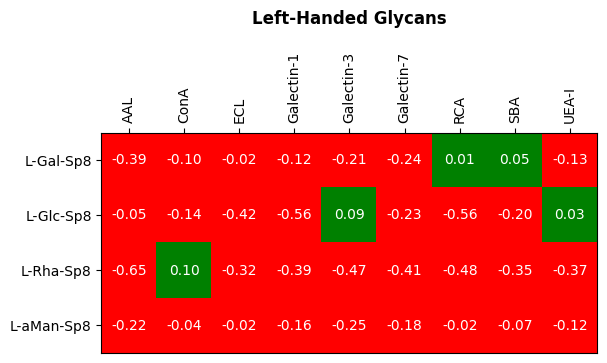

In [13]:
plot_table(left_leor_preds_df, "tables/lectinoracle_preds_lefthanded", "Left-Handed Glycans")

## Right-Handed Predictions

In [14]:
right_glycan_data = {"Name": [], "IUPAC": [], "Clean IUPAC": []}
for i, left_row in left_glycan_df.iterrows():
    left_name = left_row["Name"]
    left_iupac = left_row["IUPAC"]
    left_clean = left_row["Clean IUPAC"]
    
    right_name = "D-" + left_name[2:]
    right_iupac = "D-" + left_iupac[2:]
    if left_clean[:2] == "L-":
        right_clean = left_clean[2:]
    else:
        right_clean = "D-" + left_clean
    
    right_glycan_data["Name"].append(right_name)
    right_glycan_data["IUPAC"].append(right_iupac)
    right_glycan_data["Clean IUPAC"].append(right_clean)

right_glycan_df = pd.DataFrame(right_glycan_data)
right_glycan_df.head()

,Name,IUPAC,Clean IUPAC
0,D-aMan-Sp8,D-Man(α-Sp8,Man
1,D-Rha-Sp8,D-Rha(α-Sp8,D-Rha
2,D-Gal-Sp8,D-Gal(α-Sp8,Gal
3,D-Glc-Sp8,D-Glc(α-Sp8,Glc


In [15]:
right_leor_preds_df = get_pred_df(protein_df, right_glycan_df)
print(len(right_leor_preds_df))
right_leor_preds_df.head()

36


,glycan,protein,rfu
0,D-Glc-Sp8,SBA,-0.168248
1,D-aMan-Sp8,SBA,-0.167433
2,D-Gal-Sp8,SBA,-0.158972
3,D-Rha-Sp8,SBA,1.161801
4,D-aMan-Sp8,RCA,-0.111553


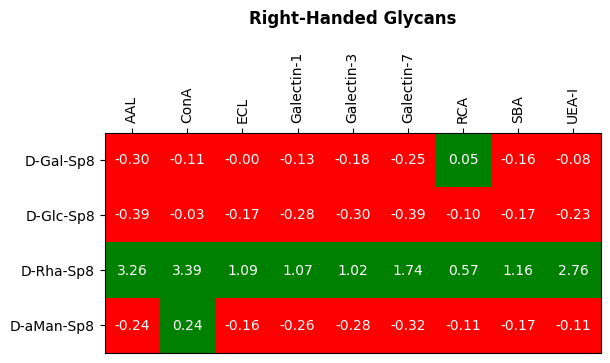

In [16]:
plot_table(right_leor_preds_df, "tables/lectinoracle_preds_righthanded", "Right-Handed Glycans")

## Large Glycans

In [17]:
large_glycan_df = pd.read_csv('data/large_glycans.txt', sep='\t')
large_glycan_df

,Name,IUPAC
0,Man3,Man(a1-3)[Man(a1-6)]Man(α-Sp8
1,LNT,Gal(β1-3)GlcNAc(β1-3)Gal(β1-4)Glc(α-Sp8
2,LeX,Gal(b1-4)[Fuc(a1-4)]GlcNAc(b1-3)Gal(α-Sp8


In [18]:
large_glycan_df["Clean IUPAC"] = get_clean_iupacs(large_glycan_df["IUPAC"])
large_glycan_df

,Name,IUPAC,Clean IUPAC
0,Man3,Man(a1-3)[Man(a1-6)]Man(α-Sp8,Man(a1-3)[Man(a1-6)]Man
1,LNT,Gal(β1-3)GlcNAc(β1-3)Gal(β1-4)Glc(α-Sp8,Gal(β1-3)GlcNAc(β1-3)Gal(β1-4)Glc
2,LeX,Gal(b1-4)[Fuc(a1-4)]GlcNAc(b1-3)Gal(α-Sp8,Gal(b1-4)[Fuc(a1-4)]GlcNAc(b1-3)Gal


In [19]:
large_leor_preds_df = get_pred_df(protein_df, large_glycan_df)
print(len(large_leor_preds_df))
large_leor_preds_df.head()

27


,glycan,protein,rfu
0,Man3,SBA,-0.074417
1,LeX,SBA,-0.055615
2,LNT,SBA,0.013474
3,Man3,RCA,-0.373763
4,LeX,RCA,0.113119


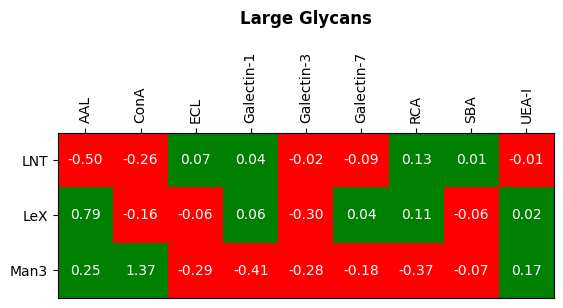

In [20]:
plot_table(large_leor_preds_df, "tables/lectinoracle_preds_large", "Large Glycans")